**Dataset:**
personality type data (Lab 2 - Personality Profile Type.csv)

**Objective:**
classify Personality type as one of the following **using RNNs**. <br>
['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']

**Evaluation metric:**
Precision

### Import used libraries

In [15]:
pip install cleantext

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import string
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import cross_val_score
import optuna
import tqdm
import spacy
import numpy as np
import seaborn as sns
from cleantext import clean
from sklearn.pipeline import Pipeline

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

### Load Dataset

In [2]:
df = pd.read_csv("Lab 2 - Personality Profile Type.csv")
df.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments https://www.youtube.com/watch?v=iz7lE1g4XM4 sportscenter not top ten plays https://www.youtube.com/watch?v=uCdfze1etec pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8 http://www.youtube.com/watch?v=u8ejam5DP3E On repeat for most of today.|||May the PerC Experience immerse you.|||The last ...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin* That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes. Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (and it can stem from any current topic/obsession) can be deadly. It's like when you're stuck in your o..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...|||Dear ENTJ sub, Long time no see. Sincerely, Alpha|||None of them. All other types hurt in deep existential ways that I want no part of.|||Probably a sliding scale that depends on individual preferences, like everything in humanity.|||Draco Malfoy also. I'd say he's either 358 or 368.|||I'm either 358..."
4,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to. Nobody wants to be approached with BS...|||But guys... he REALLY wants to go on a super-duper-long-ass vacation. C'mon guys. His boss just doesn't listen or get it. He even approached him logically and everything.|||Never mind. Just go on permanent vacation.|||Two months? I wouldn't be crazy about the idea. If you are really hi...
5,INTJ,"'18/37 @.@|||Science is not perfect. No scientist claims that it is, or that scientific information will not be revised as we discover new things. Rational thinking has been very useful to our society....|||INFP- Edgar Allen Poe was an INFP and he's in your siggy.|||People see the obvious Fi and are quick to put her as INFP. I agree that she has no Ne. I see her as an ISFP. Compare her to Haku (definite INFP). She is flat through most of Naruto.. but I don't...|||Lets get this party star..."
6,INFJ,"'No, I can't draw on my own nails (haha). Those were done by professionals on my nails. And yes, those are all gel. You mean those you posted were done by yourself on your own nails? Awesome!|||Probably the Electronic Screen Syndrome. With the advent of technology and social media, we all suffer from overstimulation on a daily basis. I'm guilty as well. In the past, I can be happy just...|||I love nail arts too! These are some of mine: 718282 718290 718298 718306 718314|||This is the first..."
7,INTJ,"'I tend to build up a collection of things on my desktop that i use frequently and then move them into a folder called 'Everything' from there it get sorted into type and sub type|||i ike to collect odd objects, even at work...a lot of people would call it junk but i like to collect it. Old unused software? ill take that off your hands :) i have a bunch of old adobe...|||i think its quite normal, i tend to only see my friends in real life every c

### Data splitting

In [3]:
x = df.posts

In [4]:
y = df.type

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### EDA on training data

- check NaNs

In [7]:
x_train.isnull().sum()

0

- check duplicates

In [8]:
df.duplicated().sum()

0

- show a representative sample of data texts to find out required preprocessing steps

In [10]:
x_train.head(10)

984     Phrases I never want to hear again a.k.a If you say any of these to me I'll escort you to the gates of hell  ''don't question me, I'm your mother/father/teacher'' ''you need to start living!''...|||some?|||That's it, I'm collecting every coin that's around the house to save for this.|||I've forgotten how alien not wanting to hurt other people's emotions at the sake of one's wellbeing is to me and how normal it is for some of my friends. Why would you stay with someone you don't...|||Why do s...
6706    'Yeah. You say you primarily value people who contribute to society.   You seem to have this all for the greater good concept, floating in head-space, which smacks of altruism. You don't care...|||...  sup? I got nothing.|||You inspirers are a cultic, manipulative lie, believed in by empty, untalented fanatics, which instead of developing their own identities, choose to shirk personal responsibility, for a world others...|||An estp in her istj shadow?|||Nope  https://www.youtube.

- check dataset balancing

In [12]:
df.type.value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

<Axes: >

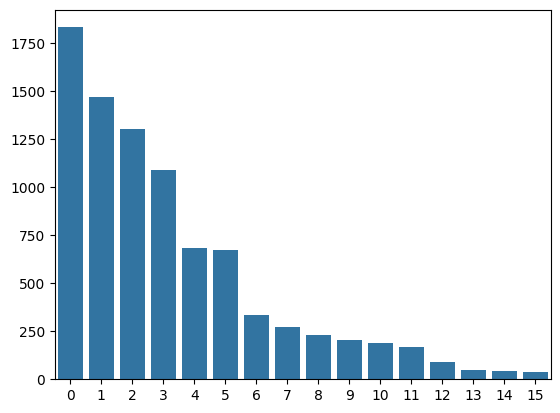

In [14]:
sns.barplot(df.type.value_counts().values)

- Cleaning and Preprocessing are:
    1. Remove some of characters.  
    2. Remove Links
    3. Remove Emojs
    4. Remove Numbers
    - ... etc.

### Cleaning and Preprocessing

In [23]:
def preprocessing(text):
    text = text.lower() # Small Case
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Links
    text = re.sub(r'\d+', '', text) # Numbers
    punctuation = string.punctuation.replace("'", '')
    text = text.translate(str.maketrans(' ', ' ', punctuation)) # Special Characters

    pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF" 
    "\U0001FA00-\U0001FA6F" 
    "\U0001FA70-\U0001FAFF"
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251" 
    "]+", flags=re.UNICODE) # Emojs
    text = pattern.sub('', text)
    
    text = text.strip() # Trail Spaces
    return text

In [24]:
x_train = x_train.apply(preprocessing)

In [26]:
x_train.head()

984     phrase never want hear aka say ill escort gate hell dont question im motherfatherteach need start livingsomethat im collect everi coin around hou save thisiv forgotten alien want hurt peopl emot sake one wellb normal friend would stay someon dontwhi peopl idol signif much god fuck dammit grow thing perfect guygirl peopl delusionalid also like point pain cramp actual cau uteru contract strongli cut blood suppli yeah tell guy come back one social skill lazi emot book smart green orang blue gol...
6706    yeah say primarili valu peopl contribut societi seem greater good concept float headspac smack altruism dont care sup got nothingi inspir cultic manipul lie believ empti untal fanat instead develop ident choo shirk person respon world othersan estp istj shadownop fan imb video prefer hyperlink want know type opinion napoleon watch debat opinion legaci thentri dogsoci rooster independ eagl hawktel adult youv got noth prove soon get reput somebodi wait bust rep make bad way get fig

**You  are doing Great so far!**

### Modelling

In [31]:
pipeline = Pipeline(steps=[
    ('Vectorizing', CountVectorizer()),
    ('model', LogisticRegression()),
])

pipeline.fit(x_train, y_train)

c:\Users\maham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('Vectorizing', CountVectorizer()),
                ('model', LogisticRegression())])

In [32]:
predictions = pipeline.predict(x_test)

In [33]:
f1_score(y_test, predictions, average='macro')

0.4308872475538201

#### Evaluation

**Evaluation metric:**
Precision

In [34]:
precision_score(y_test, predictions, average='macro')

0.5698467626895958

### Enhancement

In [35]:
nlp = spacy.load('en_core_web_md')

In [37]:
x_train_v = np.zeros((len(x_train), 300))
x_test_v = np.zeros((len(x_test), 300))

for i, doc in enumerate(nlp.pipe(x_train)):
    x_train_v[i, :] = doc.vector

for i, doc in enumerate(nlp.pipe(x_test)):
    x_test_v[i, :] = doc.vector

In [38]:
model = LogisticRegression()
model.fit(x_train_v, y_train)
predictions = model.predict(x_test_v)

f1_score(y_test, predictions, average='macro')

c:\Users\maham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.017578602146853604

### Conclusion and final results


#### Done!